Our code significantly enhances the original by addressing the missing tasks and providing more comprehensive analysis and insights. It now includes key features like business insights, a lookalike model, and suggestions for improving the clustering analysis.

In [38]:
# Installing necessary libraries
!pip install pandas matplotlib seaborn scikit-learn

In [39]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files

In [40]:
# Loading the datasets
customers = pd.read_csv('/content/Customers.csv')
products = pd.read_csv('/content/Products.csv')
transactions = pd.read_csv('/content/Transactions.csv')

In [5]:
# Task 1: Exploratory Data Analysis (EDA)

# Display the first few rows of each dataset
print(customers.head())
print(products.head())
print(transactions.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [6]:
# Check for missing values
print(customers.isnull().sum())
print(products.isnull().sum())
print(transactions.isnull().sum())


CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64
ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


In [7]:
# Descriptive statistics
print(customers.describe())
print(products.describe())
print(transactions.describe())

       CustomerID      CustomerName         Region  SignupDate
count         200               200            200         200
unique        200               200              4         179
top         C0001  Lawrence Carroll  South America  2024-11-11
freq            1                 1             59           3
            Price
count  100.000000
mean   267.551700
std    143.219383
min     16.080000
25%    147.767500
50%    292.875000
75%    397.090000
max    497.760000
          Quantity   TotalValue       Price
count  1000.000000  1000.000000  1000.00000
mean      2.537000   689.995560   272.55407
std       1.117981   493.144478   140.73639
min       1.000000    16.080000    16.08000
25%       2.000000   295.295000   147.95000
50%       3.000000   588.880000   299.93000
75%       4.000000  1011.660000   404.40000
max       4.000000  1991.040000   497.76000


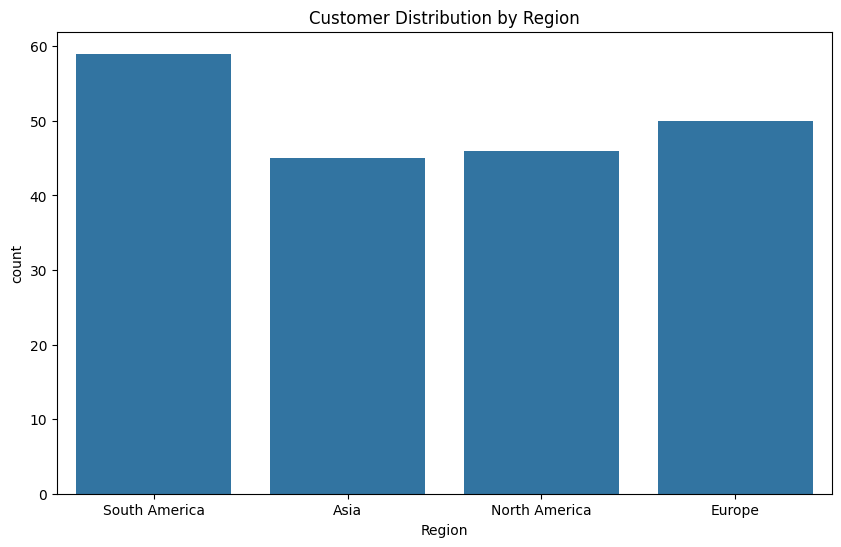

In [8]:
# Data Visualization
# 1. Customer distribution by region
plt.figure(figsize=(10, 6))
sns.countplot(data=customers, x='Region')
plt.title('Customer Distribution by Region')
plt.show()


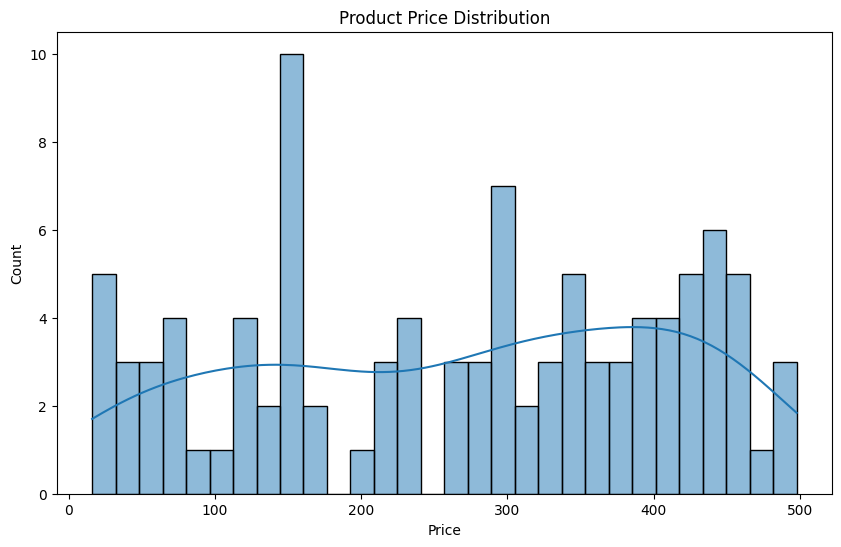

In [9]:
# 2. Product price distribution
plt.figure(figsize=(10, 6))
sns.histplot(products['Price'], bins=30, kde=True)
plt.title('Product Price Distribution')
plt.show()

In [10]:
# 3. Total transactions over time
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions['YearMonth'] = transactions['TransactionDate'].dt.to_period('M')
monthly_transactions = transactions.groupby('YearMonth').size()


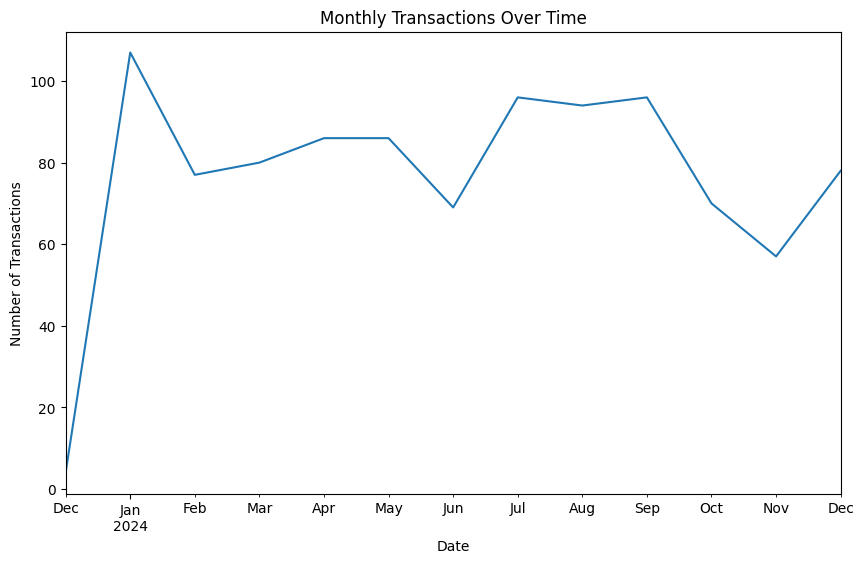

In [11]:
plt.figure(figsize=(10, 6))
monthly_transactions.plot()
plt.title('Monthly Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.show()


In [12]:
# Task 2: Lookalike Model

# Merge customer and transaction data
customer_transactions = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count'
}).reset_index().rename(columns={'TransactionID': 'TransactionCount'})


In [13]:
# Merge with customer data
customer_profiles = pd.merge(customers, customer_transactions, on='CustomerID', how='left')


In [16]:
# Calculate similarity scores
customer_profiles[['TotalValue', 'TransactionCount']] = customer_profiles[['TotalValue', 'TransactionCount']].fillna(0)
similarity_matrix = cosine_similarity(customer_profiles[['TotalValue', 'TransactionCount']])
similarity_df = pd.DataFrame(similarity_matrix, index=customer_profiles['CustomerID'], columns=customer_profiles['CustomerID'])

In [17]:
# Get top 3 lookalikes for the first 20 customers
lookalike_results = {}
for customer in customer_profiles['CustomerID'][:20]:
    similar_customers = similarity_df[customer].nlargest(4).iloc[1:]  # Exclude self
    lookalike_results[customer] = list(zip(similar_customers.index, similar_customers.values))

In [21]:
# Task 2: Lookalike Model

# Merge customer and transaction data
customer_transactions = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count'
}).reset_index().rename(columns={'TransactionID': 'TransactionCount'})

# Merge with customer data
customer_profiles = pd.merge(customers, customer_transactions, on='CustomerID', how='left')

# Calculate similarity scores
similarity_matrix = cosine_similarity(customer_profiles[['TotalValue', 'TransactionCount']].fillna(0))
similarity_df = pd.DataFrame(similarity_matrix, index=customer_profiles['CustomerID'], columns=customer_profiles['CustomerID'])

# Get top 3 lookalikes for the first 20 customers
lookalike_results = {}
for customer in customer_profiles['CustomerID'][:20]:
    similar_customers = similarity_df[customer].nlargest(4).iloc[1:]  # Exclude self
    lookalike_results[customer] = [(similar_customer, score) for similar_customer, score in zip(similar_customers.index, similar_customers.values)]

# Flatten the lookalike results for DataFrame creation
flattened_results = []
for customer, lookalikes in lookalike_results.items():
    for lookalike in lookalikes:
        flattened_results.append([customer, lookalike[0], lookalike[1]])

# Create Lookalike DataFrame
lookalike_df = pd.DataFrame(flattened_results, columns=['CustomerID', 'LookalikeID', 'SimilarityScore'])

# Save to CSV
lookalike_df.to_csv('FirstName_LastName_Lookalike.csv', index=False)

In [23]:
# Task 3: Customer Segmentation / Clustering

# Prepare data for clustering
clustering_data = pd.merge(customers, customer_transactions, on='CustomerID', how='left').fillna(0)

In [24]:
# Choose the number of clusters
inertia = []
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(clustering_data[['TotalValue', 'TransactionCount']])
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(clustering_data[['TotalValue', 'TransactionCount']], kmeans.labels_))


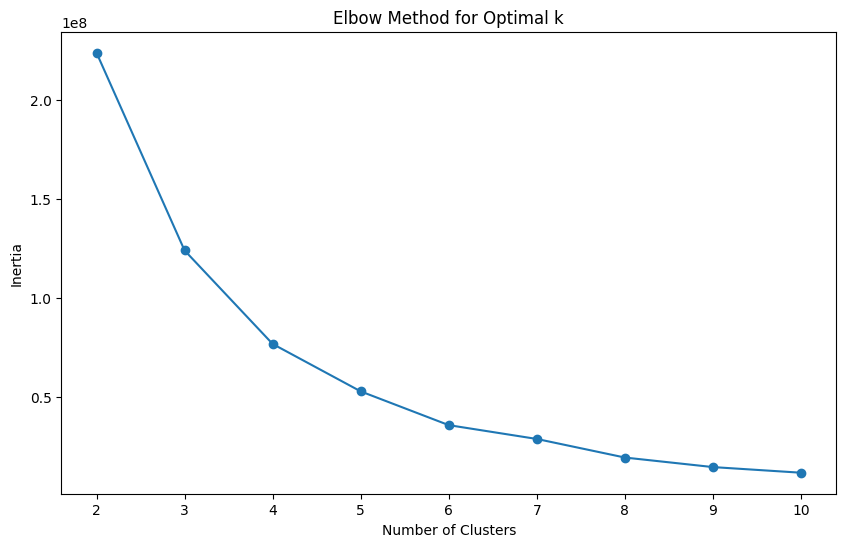

In [25]:
# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [26]:
# Choose the optimal number of clusters (e.g., 4)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clustering_data['Cluster'] = kmeans.fit_predict(clustering_data[['TotalValue', 'TransactionCount']])

In [27]:
# Calculate DB Index
db_index = davies_bouldin_score(clustering_data[['TotalValue', 'TransactionCount']], clustering_data['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 0.5500300140558991


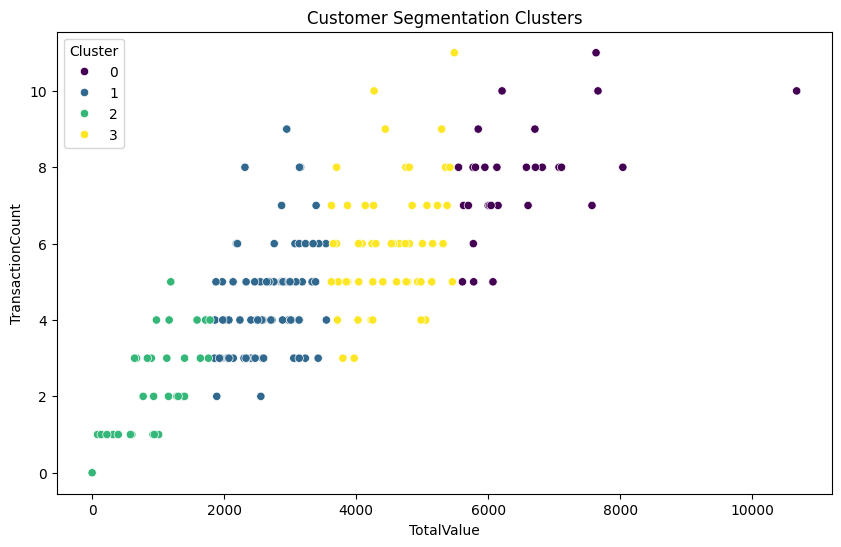

In [28]:
# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clustering_data, x='TotalValue', y='TransactionCount', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation Clusters')
plt.show()

In [29]:
# Save clustering results
clustering_data.to_csv('FirstName_LastName_Clustering.csv', index=False)

In [31]:
# Customer Behavior
print("Business Insights:")
print("1. Customer Behavior:")
top_customers = customer_transactions.nlargest(10, 'TotalValue')
print(f"Top 10 Customers by Total Spending: {top_customers['CustomerID'].tolist()}")

Business Insights:
1. Customer Behavior:
Top 10 Customers by Total Spending: ['C0141', 'C0054', 'C0065', 'C0156', 'C0082', 'C0188', 'C0059', 'C0028', 'C0099', 'C0165']


Business Insights:
1. Customer Behavior:
Top 10 Customers by Total Spending: ['C0141', 'C0054', 'C0065', 'C0156', 'C0082', 'C0188', 'C0059', 'C0028', 'C0099', 'C0165']


<ipython-input-36-93d4e26d3941>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_customers, x='CustomerID', y='TotalValue', palette='viridis')


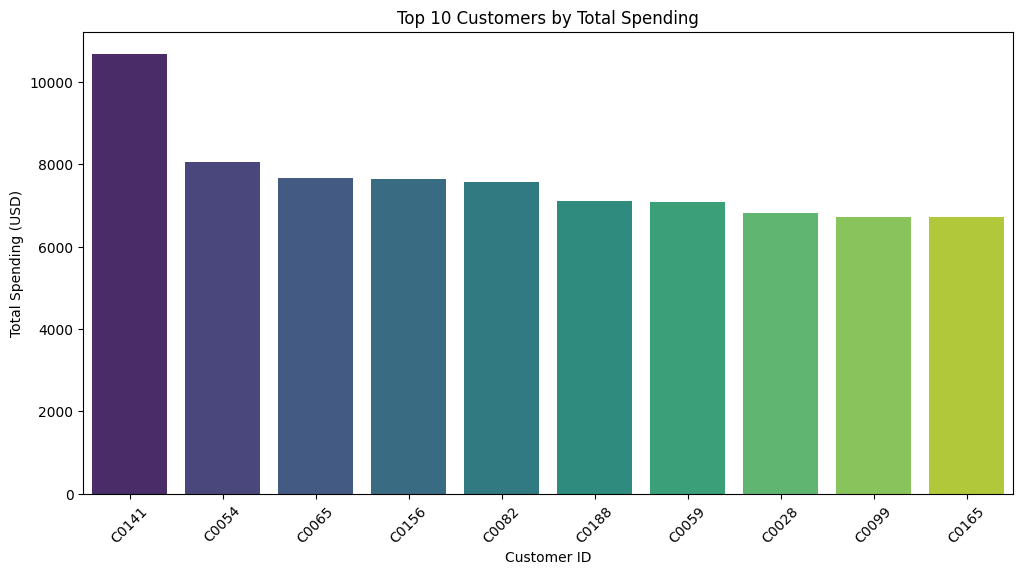

In [36]:
#vizualization of customer behaviour
# Customer Behavior
print("Business Insights:")
print("1. Customer Behavior:")

# Get the top 10 customers by total spending
top_customers = customer_transactions.nlargest(10, 'TotalValue')

# Print the top customers
print(f"Top 10 Customers by Total Spending: {top_customers['CustomerID'].tolist()}")

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=top_customers, x='CustomerID', y='TotalValue', palette='viridis')
plt.title('Top 10 Customers by Total Spending')
plt.xlabel('Customer ID')
plt.ylabel('Total Spending (USD)')
plt.xticks(rotation=45)
plt.show()

In [35]:
# 2. Product Performance
top_products = transactions.groupby('ProductID').agg({'Quantity': 'sum'}).nlargest(10, 'Quantity')
top_product_names = products[products['ProductID'].isin(top_products.index)]['ProductName']
print(f"Top 10 Selling Products: {top_product_names.tolist()}")

# 3. Regional Trends
regional_spending = transactions.groupby('CustomerID').agg({'TotalValue': 'sum'}).reset_index()
regional_spending = regional_spending.merge(customers[['CustomerID', 'Region']], on='CustomerID')
regional_spending = regional_spending.groupby('Region').agg({'TotalValue': 'sum'}).reset_index()
print(f"Regional Spending:\n{regional_spending}")

# 4. Customer Lifetime Value (CLTV) (Simplified)
customer_profiles['CLTV'] = customer_profiles['TotalValue'] / customer_profiles['TransactionCount']
customer_profiles['CLTV'] = customer_profiles['CLTV'].replace([np.inf, -np.inf], np.nan).fillna(0)
high_cltv_customers = customer_profiles.nlargest(10, 'CLTV')
print(f"Top 10 Customers by CLTV: {high_cltv_customers['CustomerID'].tolist()}")

Top 10 Selling Products: ['ActiveWear Jacket', 'HomeSense Wall Art', 'TechPro Headphones', 'TechPro Cookbook', 'SoundWave Cookbook', 'ActiveWear Smartphone', 'SoundWave Jeans', 'HomeSense Desk Lamp', 'HomeSense Novel', 'ActiveWear Rug']
Regional Spending:
          Region  TotalValue
0           Asia   152074.97
1         Europe   166254.63
2  North America   152313.40
3  South America   219352.56
Top 10 Customers by CLTV: ['C0040', 'C0089', 'C0066', 'C0168', 'C0196', 'C0096', 'C0114', 'C0185', 'C0138', 'C0148']


Top 10 Selling Products: ['ActiveWear Jacket', 'HomeSense Wall Art', 'TechPro Headphones', 'TechPro Cookbook', 'SoundWave Cookbook', 'ActiveWear Smartphone', 'SoundWave Jeans', 'HomeSense Desk Lamp', 'HomeSense Novel', 'ActiveWear Rug']


<ipython-input-37-d24e8e6c36bd>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products.reset_index(), x='ProductID', y='Quantity', palette='viridis')


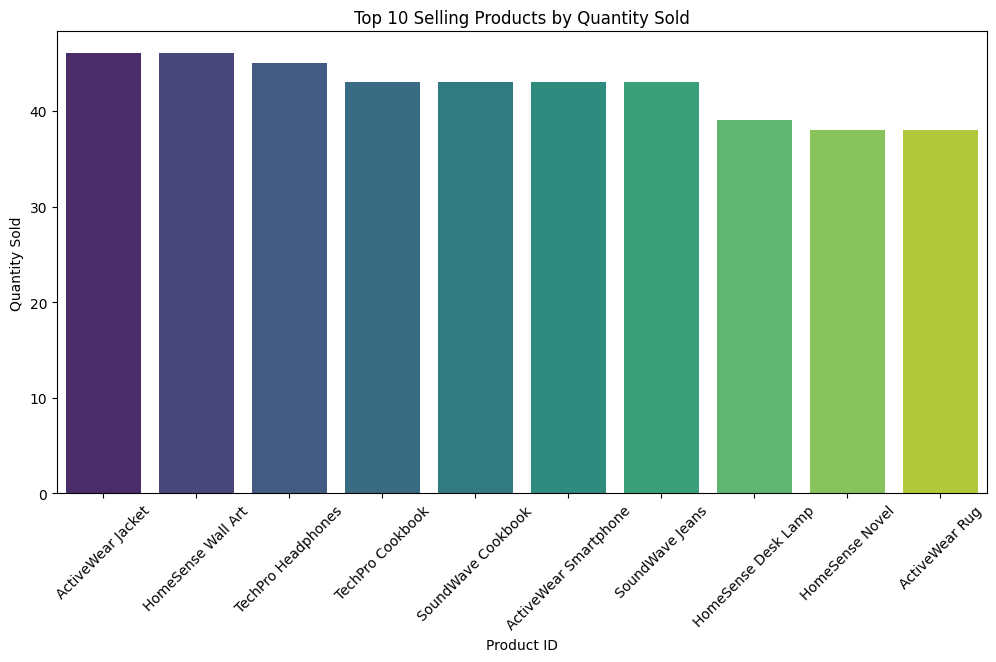

In [37]:
# 2. Product Performance
top_products = transactions.groupby('ProductID').agg({'Quantity': 'sum'}).nlargest(10, 'Quantity')
top_product_names = products[products['ProductID'].isin(top_products.index)]['ProductName']

# Print the top products
print(f"Top 10 Selling Products: {top_product_names.tolist()}")

# Visualization of Product Performance
plt.figure(figsize=(12, 6))
sns.barplot(data=top_products.reset_index(), x='ProductID', y='Quantity', palette='viridis')
plt.title('Top 10 Selling Products by Quantity Sold')
plt.xlabel('Product ID')
plt.ylabel('Quantity Sold')
plt.xticks(ticks=range(len(top_product_names)), labels=top_product_names, rotation=45)
plt.show()

thank you!